In [10]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

### We have already made cuts in `NSA-structure-vanilla-cuts-all.ipynb`. Now we select UDGs, make visual inspection, and plot some useful figures

In [8]:
# input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel.fits')
# from sample_cuts import post_process_cat_new
# cuts_cat_old = post_process_cat_new(input_cuts_cat)

In [71]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
from sample_cuts import post_process_cat_new_rbf
cuts_cat = post_process_cat_new_rbf(input_cuts_cat)

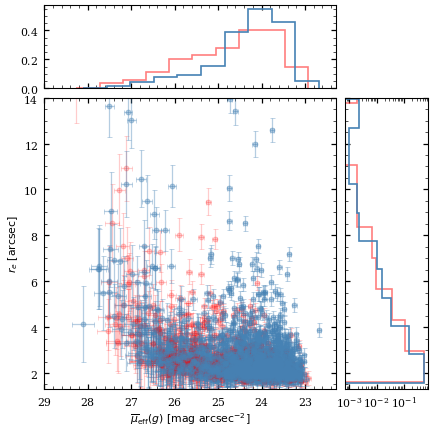

In [73]:
# Distribution of the full sample after junk cuts
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = (cuts_cat['g-i'].data > 0.8)

ax.errorbar(cuts_cat[red]['SB_eff_avg'][:, 0], 
            cuts_cat[red]['rhalf_spergel'], 
            xerr=cuts_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=cuts_cat[red]['rhalf_spergel_err'],
            color='r', fmt='o', alpha=0.2)

ax.errorbar(cuts_cat[~red]['SB_eff_avg'][:, 0], 
            cuts_cat[~red]['rhalf_spergel'], 
            xerr=cuts_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=cuts_cat[~red]['rhalf_spergel_err'],
            color='steelblue', fmt='o', alpha=0.4)

ax.set_xlim(29, 22.3)
ax.set_ylim(1.3, 14)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(cuts_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(cuts_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(cuts_cat[red]['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(cuts_cat[~red]['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

In [74]:
### Very conservative choise of UDG, including the measurement error
flag = (cuts_cat['rhalf_phys'] + cuts_cat['rhalf_phys_err'] >= 1.5
       ) & (cuts_cat['SB_eff_avg'][:, 0] + cuts_cat['SB_eff_avg_err'][:, 0] >= 24.5)

print('# of UDGs:', np.sum(flag))

# of UDGs: 633


In [75]:
udg_cat = cuts_cat[flag]

In [76]:
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 495
# of Gal: 117
# of Junk: 21


In [77]:
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_w_missed.txt', 
    format='ascii', overwrite=True)

---
### Visual inspection: mark junks

In [78]:
cuts_cat[cuts_cat['viz-id'] == 79056]

viz-id,ra,dec,image_flag,psf_flag,radius,flux,mag,mag_err,g-i,g-i_err,g-r,g-r_err,SB_eff_avg,SB_eff_avg_err,rhalf_spergel,rhalf_spergel_err,rhalf_phys,rhalf_phys_err,abs_mag,abs_mag_err,log_ML_g,log_ML_g_err,log_m_star,log_m_star_err,completeness,tract,patch,synth_id,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,A_g,A_r,A_i,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_nvotes,host_spiral,host_elliptical,host_uncertain,host_RA,host_DEC,SB_eff_circ,SB_0,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circularized,spergel_nu,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,S,A_outer,A_shape,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,flag_sersic
,deg,deg,,,arcmin,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),arcsec,arcsec,kpc,kpc,mag(AB),mag(AB),,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,bool[5],bool[5],float64,float64[4],float64[3],float64[3],float64,float64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64,int64,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[4],float64[4],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
79056,350.2807349,1.4006702,True .. True,True .. True,0.7,375.47442697678514 .. 980.816781226347,20.372682289227868 .. 19.523978693790337,0.17922002523001146 .. 0.19178430213657582,0.7878199424948968,0.07596619371489623,0.2261981034066683,0.05268315140497659,26.459286284864362 .. 25.61058268942683,0.11317020849108732 .. 0.10783120729714334,6.58007532116614,0.9371704436058204,4.139001739964775,0.5894993457370655,-15.322930591743836 .. -16.17163418718137,0.17922002523001146 .. 0.19178430213657582,-0.10746104957034469,0.0985281532482204,8.033711187127189,0.12184813405816337,0.713285500132067,9705,"1,7",-1,21.7703,20.6046,20.2358,3.642828,6.3060480000000005,0.12317700248030716,0.08728688916869276,0.06229334953767467,0,0,0,2,0,0,2,0,2,J232119.40+012410.9,0.03042442724108696,129.74489686275106,11.04596075368844,13.100223541259766,602.7204718289128,0.2661633849232924,0.13248100771273208,--,--,--,--,350.3307495893224,1.4031426948407324,27.210615174193563 .. 26.16809636269701,25.748860637971664 .. 24.70634182647511,0.5449012879038678,0.544901306722338,-1.5518726929787832,-1.5518727097555995,5.788563848890138,1.452804543305469,18.452671439236987,36.24818271567082,63.081672400244756,0.47012062396457505,-1.6840770447444993,-0.46583751936741535,-0.09566729149455613,2.6692197486925737,0.0003302894642516881,0.012284582270289163,0.000677343262163398,0.1670427144539211,0.7493247535854362,52.10264668149974,0.5687636321098563,1.5893153854698399,0.0


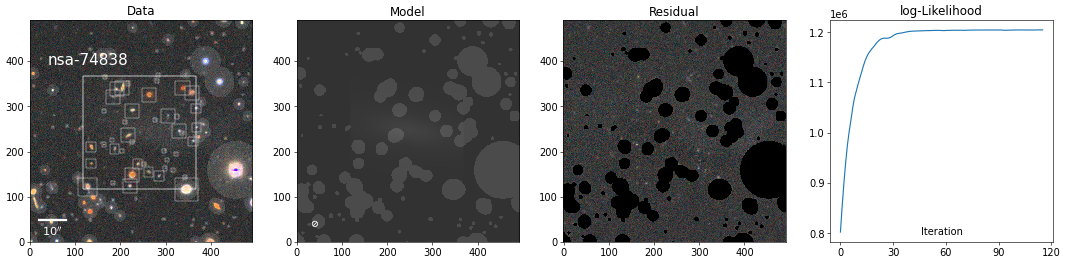

In [79]:
method = 'spergel'
Image.open(f'./Figure/nsa_z002_004/{method}/nsa-74838-zoomin-{method}.png')

In [80]:
votes = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_votes_w_missed.txt',
                   format='ascii')
flag = ~(votes['marked'] == 'true')

In [81]:
udg_cat = udg_cat[flag]

In [82]:
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UDGs:', len(udg_cat))
print('UDG hosts:', len(np.unique(udg_cat['host_name'])))

print('UDG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Hosts for LSBGs after cuts: 689

LSBGs after cuts: 2510
UDGs: 611
UDG hosts: 358
UDG fraction: 0.8867924528301887

# of Candy: 487
# of Gal: 111
# of Junk: 13


In [83]:
udg_cat.write(f'/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz_w_missed.fits', 
              overwrite=True)
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz_w_missed.txt', 
    format='ascii', overwrite=True)

---

In [69]:
udg_cat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz_w_missed.fits')

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

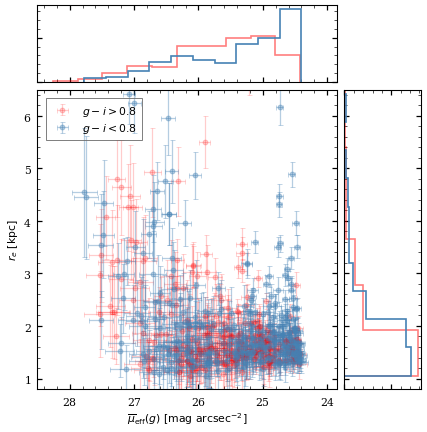

In [70]:
# Distribution of the full sample after junk cuts
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 1.8), height_ratios=(1.8, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.04, hspace=0.04)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = (udg_cat['g-i'].data > 0.8)

ax.errorbar(udg_cat[red]['SB_eff_avg'][:, 0], 
            udg_cat[red]['rhalf_phys'], 
            xerr=udg_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[red]['rhalf_phys_err'],
            color='r', fmt='o', alpha=0.2, label='$g-i > 0.8$')

ax.errorbar(udg_cat[~red]['SB_eff_avg'][:, 0], 
            udg_cat[~red]['rhalf_phys'], 
            xerr=udg_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[~red]['rhalf_phys_err'],
            color='steelblue', fmt='o', alpha=0.4, label='$g-i < 0.8$')

leg = ax.legend(loc='upper left', frameon=True)
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('dimgray')
leg.get_frame().set_boxstyle('Square', pad=0.)

ax.set_xlim(28.5, 23.85)
ax.set_ylim(0.8, 6.5)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm kpc]$')

ax_histx.hist(udg_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(udg_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(udg_cat[red]['rhalf_phys'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(udg_cat[~red]['rhalf_phys'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histx.set_yticklabels([])
ax_histy.set_xticklabels([])
# ax_histy.set_xscale('log')

In [49]:
kz.set_matplotlib(style='default', usetex=False, dpi=60, fontsize=13)

Text(0.5, 0, '$d_{\\rm ang} / R_{\\rm vir, ang}$')

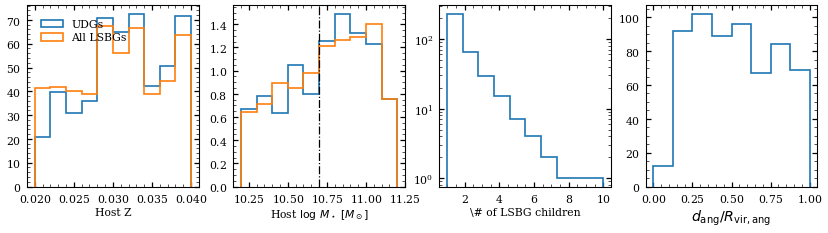

In [51]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(udg_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel('Host Z')
plt.legend(loc='upper left')

plt.sca(axes[1])
plt.hist(udg_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(udg_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('\# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=8, histtype='step', lw=2);
plt.xlabel(r'$d_{\rm ang} / R_{\rm vir, ang}$', fontsize=17)

(array([  3.,   4.,  11.,  31.,  68.,  92., 146., 187.,  54.,  15.]),
 array([0.06027711, 0.17282974, 0.28538238, 0.39793501, 0.51048765,
        0.62304028, 0.73559292, 0.84814555, 0.96069819, 1.07325082,
        1.18580346]),
 <BarContainer object of 10 artists>)

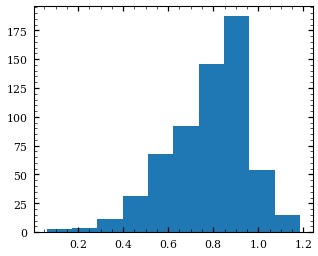

In [52]:
plt.hist(udg_cat['g-i'])

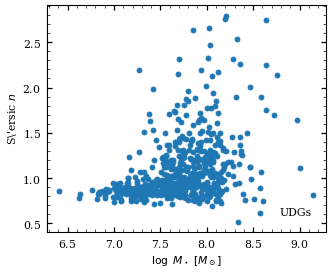

In [53]:
sct = plt.scatter(udg_cat['log_m_star'], 
            udg_cat['sersic_n'], 
            label='UDGs')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'S\'ersic $n$')
plt.legend(loc='lower right')

(array([  8.,  11.,   8.,   9.,  14.,  25.,  41.,  55.,  86., 354.]),
 array([0.00275438, 0.09669353, 0.19063268, 0.28457183, 0.37851098,
        0.47245013, 0.56638928, 0.66032843, 0.75426758, 0.84820673,
        0.94214588]),
 <BarContainer object of 10 artists>)

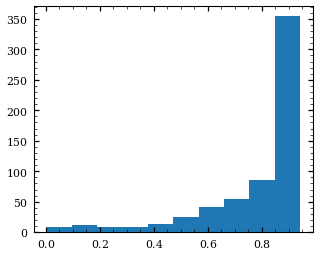

In [84]:
plt.hist(udg_cat['completeness'])

In [55]:
from scipy.stats import binned_statistic
quench_frac, bin_edges, _ = binned_statistic(np.nan_to_num(udg_cat['log_m_star'].data), (udg_cat['g-i'].data > 0.7), 
                                             statistic='mean', range=(7, 9), bins=8)
num, bin_edges, _ = binned_statistic(np.nan_to_num(udg_cat['log_m_star'].data), (udg_cat['g-i'] > 0.7), 
                                             statistic='count', range=(7, 9), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

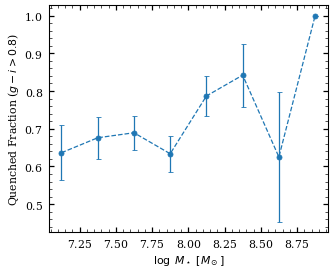

In [344]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

---